### 必要なモジュールのimport

In [18]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score, mean_squared_error
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [19]:
# データの読み込み(02_data_preparation.ipynbで作成したデータ)
train = pd.read_csv('../data/processed/processed20240627_train.csv')
test = pd.read_csv('../data/processed/processed20240627_test.csv')

## XGboostモデルの作成

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [21]:

# 特徴量と目的変数の設定
X = train.drop(columns=['target'])
y = train['target']


In [22]:
# 日付データの変換
if 'first_active_month' in X.columns:
    X['first_active_month'] = pd.to_datetime(X['first_active_month'])
    X['first_active_month_year'] = X['first_active_month'].dt.year
    X['first_active_month_month'] = X['first_active_month'].dt.month
    X = X.drop(columns=['first_active_month'])

In [23]:
# カテゴリカルデータの頻度ベースエンコーディング
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    freq_encoding = X[col].value_counts(normalize=True)
    X[col + '_freq'] = X[col].map(freq_encoding)
X = X.drop(columns=categorical_cols)

In [24]:
def objective(trial):
    # ハイパーパラメータの設定
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': trial.suggest_loguniform('eta', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10),
        'seed': 42
    }

    # KFoldクロスバリデーションの設定
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    # 各分割での学習と評価
    for fold, (train_index, valid_index) in enumerate(kf.split(X)):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # DMatrixに変換
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        
        # モデルの訓練
        model = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(dvalid, 'valid')], verbose_eval=False)
        
        # モデルを保存
        with open(f'../src/models/model_fold_{fold}.pkl', 'wb') as f:
            pickle.dump(model, f)
        
        # 予測と評価
        preds = model.predict(dvalid)
        rmse = mean_squared_error(y_valid, preds, squared=False)
        rmse_scores.append(rmse)
    
    return np.mean(rmse_scores)

In [25]:
# Optunaのスタディを作成し、最適化を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-28 00:54:15,019] A new study created in memory with name: no-name-6cd773cd-3a38-4ec6-bfc8-b2190b246a35
[I 2024-06-28 00:54:46,195] Trial 0 finished with value: 3.6851347558016108 and parameters: {'eta': 0.05739917892011629, 'max_depth': 9, 'min_child_weight': 2.560717911967056, 'subsample': 0.8260866885206201, 'colsample_bytree': 0.6457695534563829, 'lambda': 0.28351270785573446, 'alpha': 0.0010713668991617898}. Best is trial 0 with value: 3.6851347558016108.
[I 2024-06-28 00:55:07,466] Trial 1 finished with value: 3.6707129163515098 and parameters: {'eta': 0.1649531454121281, 'max_depth': 4, 'min_child_weight': 8.069925693350136, 'subsample': 0.9935661833010194, 'colsample_bytree': 0.852233213225551, 'lambda': 0.002087915784307277, 'alpha': 0.3826341049482554}. Best is trial 1 with value: 3.6707129163515098.
[I 2024-06-28 00:56:21,996] Trial 2 finished with value: 3.664359068794803 and parameters: {'eta': 0.02002902855131724, 'max_depth': 5, 'min_child_weight': 3.4610366121

In [26]:
# 最適なハイパーパラメータを取得
best_params = study.best_params
print("Best parameters: ", best_params)

Best parameters:  {'eta': 0.01508808112793922, 'max_depth': 6, 'min_child_weight': 5.855400089182723, 'subsample': 0.8161817259800525, 'colsample_bytree': 0.5904552264073462, 'lambda': 4.968848495223303, 'alpha': 2.708436241079213}


In [27]:
# 日付データの変換
def preprocess_data(df):
    if 'first_active_month' in df.columns:
        df['first_active_month'] = pd.to_datetime(df['first_active_month'])
        df['first_active_month_year'] = df['first_active_month'].dt.year
        df['first_active_month_month'] = df['first_active_month'].dt.month
        df = df.drop(columns=['first_active_month'])
    
    # カテゴリカルデータの頻度ベースエンコーディング
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        freq_encoding = df[col].value_counts(normalize=True)
        df[col + '_freq'] = df[col].map(freq_encoding)
    df = df.drop(columns=categorical_cols)
    
    return df

In [28]:
test = preprocess_data(test)

In [29]:
# KFoldクロスバリデーションでの学習と予測
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = np.zeros(len(test))

# 各分割での学習と予測の集約
for train_index, valid_index in kf.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # DMatrixに変換
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    dtest = xgb.DMatrix(test)
    
    # モデルの訓練
    model = xgb.train(best_params, dtrain, num_boost_round=1000, early_stopping_rounds=10, evals=[(dvalid, 'valid')], verbose_eval=10)
    
    # 予測の集約
    predictions += model.predict(dtest) / kf.n_splits

[0]	valid-rmse:3.87222
[10]	valid-rmse:3.83623
[20]	valid-rmse:3.80770
[30]	valid-rmse:3.78614
[40]	valid-rmse:3.76898
[50]	valid-rmse:3.75534
[60]	valid-rmse:3.74449
[70]	valid-rmse:3.73582
[80]	valid-rmse:3.72832
[90]	valid-rmse:3.72263
[100]	valid-rmse:3.71816
[110]	valid-rmse:3.71439
[120]	valid-rmse:3.71132
[130]	valid-rmse:3.70864
[140]	valid-rmse:3.70585
[150]	valid-rmse:3.70364
[160]	valid-rmse:3.70177
[170]	valid-rmse:3.70006
[180]	valid-rmse:3.69882
[190]	valid-rmse:3.69752
[200]	valid-rmse:3.69633
[210]	valid-rmse:3.69541
[220]	valid-rmse:3.69427
[230]	valid-rmse:3.69327
[240]	valid-rmse:3.69260
[250]	valid-rmse:3.69199
[260]	valid-rmse:3.69144
[270]	valid-rmse:3.69087
[280]	valid-rmse:3.68994
[290]	valid-rmse:3.68966
[300]	valid-rmse:3.68913
[310]	valid-rmse:3.68876
[320]	valid-rmse:3.68800
[330]	valid-rmse:3.68790
[340]	valid-rmse:3.68760
[350]	valid-rmse:3.68742
[360]	valid-rmse:3.68720
[370]	valid-rmse:3.68687
[380]	valid-rmse:3.68660
[390]	valid-rmse:3.68643
[400]	valid

## 提出ファイルの作成

C:\Users\kento.nishino.ek\AppData\Local\Temp\ipykernel_28608\1285291063.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions)


<Axes: ylabel='Density'>

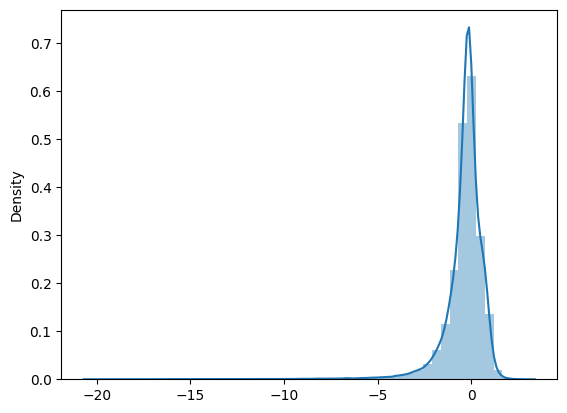

In [30]:
# 目的変数の分布を確認
# sns.distplot(predictions_original_scale)
sns.distplot(predictions)

In [31]:
test = pd.read_csv('../data/processed/processed20240627_test.csv')

In [32]:
# 提出用ファイルの作成
sub_df = pd.DataFrame({'card_id': test['card_id'].values})
sub_df['target'] = predictions
sub_df.to_csv('submission.csv', index=False)

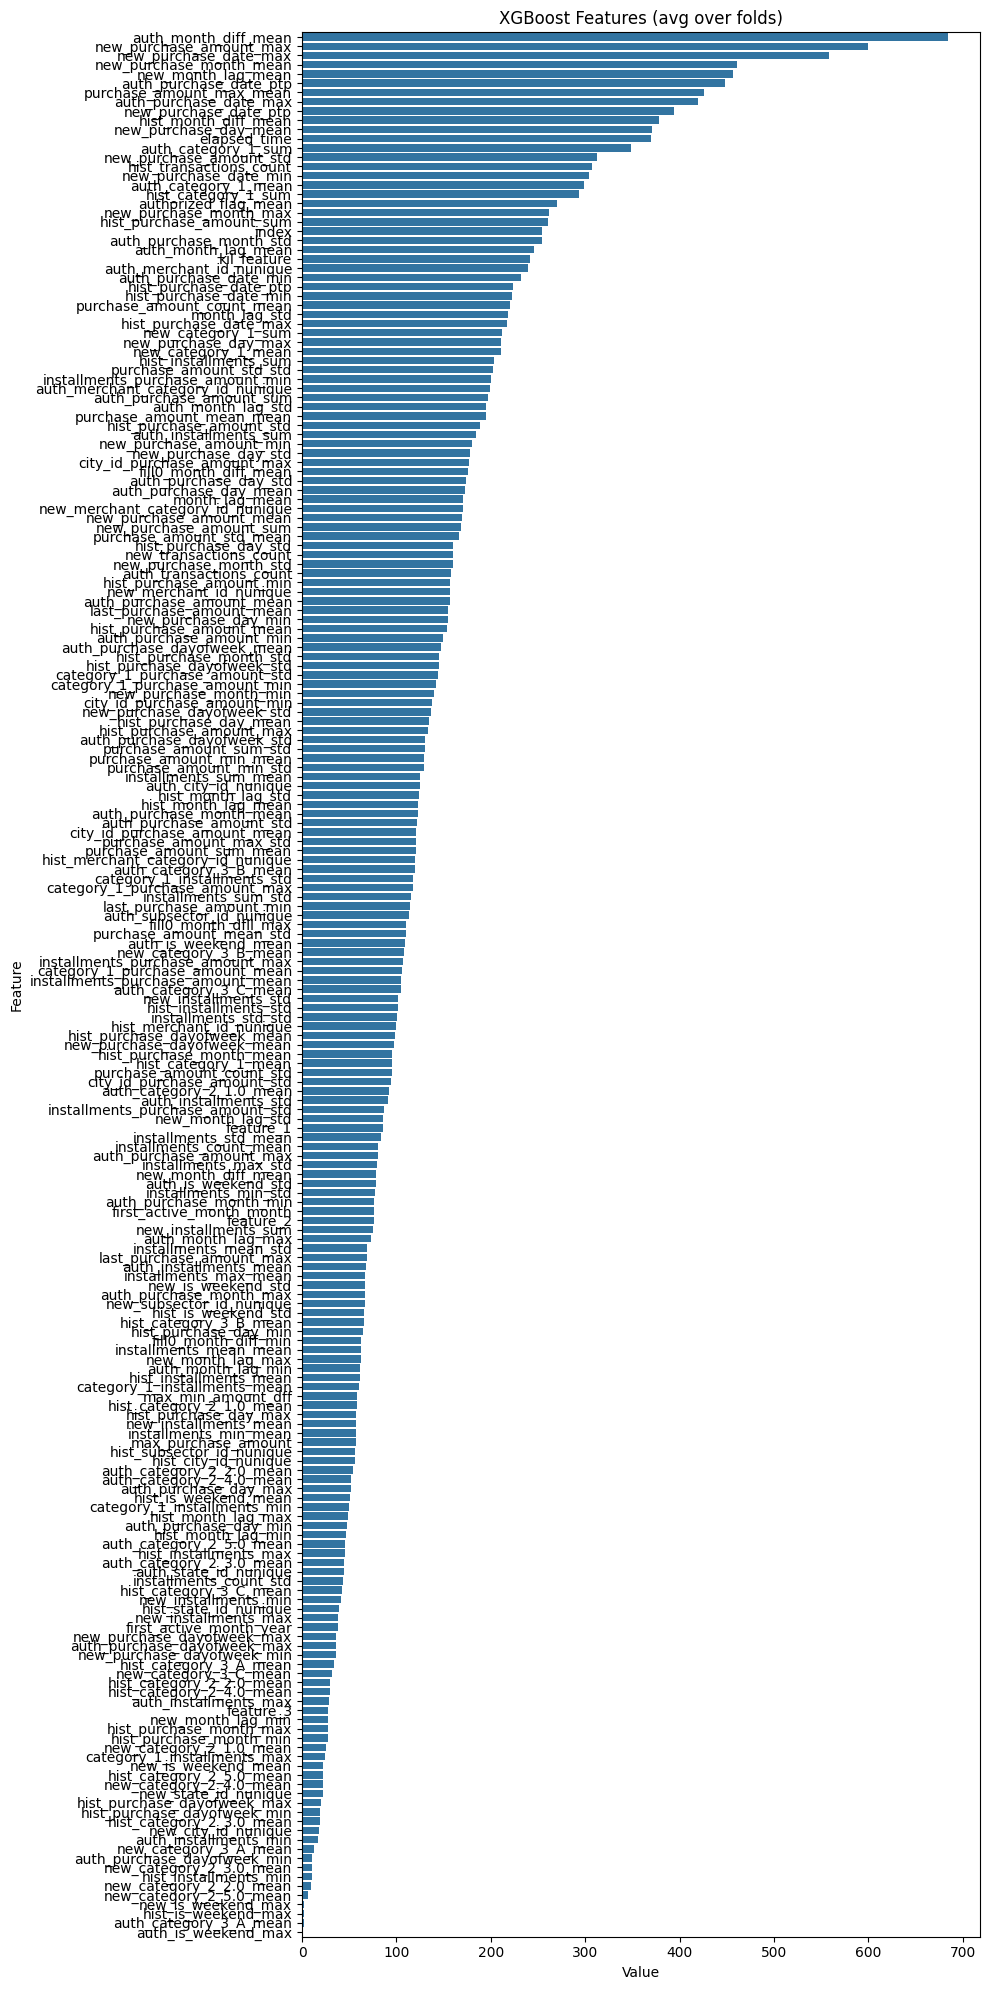

In [33]:
# 特徴量重要度の可視化を改善する関数
def plot_feature_importance(importance, features, title):
    feature_imp = pd.DataFrame({'Value': importance, 'Feature': features})
    plt.figure(figsize=(10, 20))  # グラフを縦に長く表示
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# XGBoostのモデルから特徴量重要度を取得
importance = model.get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

plot_feature_importance(importance_df['Importance'], importance_df['Feature'], 'XGBoost Features (avg over folds)')
